In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torch.utils import data
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
data_root='/content/drive/My Drive/12th Grade 2020 - 2021/Senior Project/Project/Datasets'
# total_ds_imf = torchvision.datasets.ImageFolder(root=data_root, transform=transforms.ToTensor())

Mounted at /content/drive


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.66972744, 0.53412294, 0.85122865), (0.1290, 0.1743, 0.0742))  # first element is mean of RGB vals, second element is the standard deviation of RBG vals
train_tfms = transforms.Compose([transforms.RandomCrop(588, padding=4, padding_mode='reflect'),  #change 32
                         transforms.RandomHorizontalFlip(), 
                         # transforms.RandomRotate
                         # transforms.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)]) # just a series of adjustments we want to do on the dataset
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [ ]:
train_ds = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/12th Grade 2020 - 2021/Senior Project/Project/SeparatedData/train", transform=train_tfms)
valid_ds = torchvision.datasets.ImageFolder(root="/content/drive/My Drive/12th Grade 2020 - 2021/Senior Project/Project/SeparatedData/test", transform=valid_tfms)

In [ ]:
batch_size = 15

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.max1 = nn.MaxPool2d((3,3))
        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True)
        self.conv4 = conv_block(128, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(256, num_classes))
    def forward(self, xb):
        out = self.max1(xb)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 3), device)
model

ResNet9(
  (max1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps

In [ ]:
torch.cuda.empty_cache()

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    # for batch in val_loader:
    #     print("size of batch",len(batch[0]))
    #     break
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.30566665530204773, 'val_loss': 1.0988389253616333}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [ ]:
epochs = 10
max_lr = 0.00001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 0.6552, val_loss: 0.3325, val_acc: 0.8827
Epoch [1], last_lr: 0.00001, train_loss: 0.3416, val_loss: 0.2239, val_acc: 0.9050
Epoch [2], last_lr: 0.00001, train_loss: 0.2663, val_loss: 0.1667, val_acc: 0.9380
Epoch [3], last_lr: 0.00001, train_loss: 0.2214, val_loss: 0.1555, val_acc: 0.9450
Epoch [4], last_lr: 0.00001, train_loss: 0.1890, val_loss: 0.1383, val_acc: 0.9370
Epoch [5], last_lr: 0.00001, train_loss: 0.1751, val_loss: 0.1084, val_acc: 0.9593
Epoch [6], last_lr: 0.00000, train_loss: 0.1604, val_loss: 0.1061, val_acc: 0.9637
Epoch [7], last_lr: 0.00000, train_loss: 0.1502, val_loss: 0.0911, val_acc: 0.9637
Epoch [8], last_lr: 0.00000, train_loss: 0.1464, val_loss: 0.0958, val_acc: 0.9667
Epoch [9], last_lr: 0.00000, train_loss: 0.1403, val_loss: 0.0887, val_acc: 0.9700
CPU times: user 5min 24s, sys: 3min 8s, total: 8min 33s
Wall time: 1h 7min 36s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

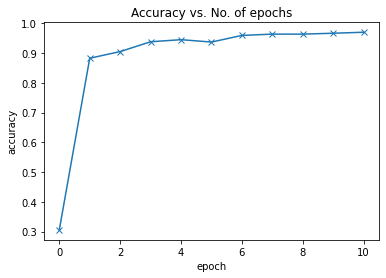

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

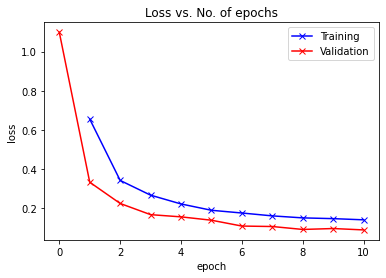

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

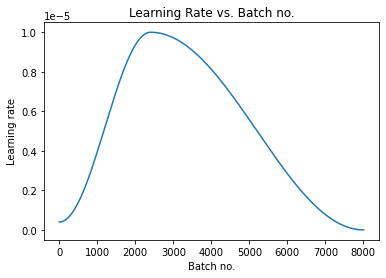

In [ ]:
plot_lrs(history)

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: lung_aca , Predicted: lung_aca


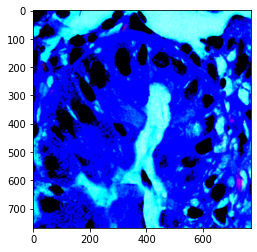

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

note that this image has been normalized to fit the proper color distribution to see this image unormalized we can use the following function:


```
def denormalize(img):
  inv_normalize = transforms.Normalize(
    mean=[-0.66972744/0.1290, -0.53412294/0.1743, -0.85122865/0.0742],
    std=[1/0.1290, 1/0.1743, 1/0.0742]
  )
  inv_tensor = inv_normalize(img.clamp(0, 1))
  return inv_tensor.permute(1, 2, 0) #can directly use plt.imshow on this
```



In [ ]:
torch.save(model.state_dict(), 'ResNet2.pth')

In [ ]:
files.download('ResNet2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>